In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk
from IPython.display import display, Markdown
from scipy.fft import dct
from scipy.signal import correlate
import os
from glob import glob
import librosa
import librosa.display
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor
import math



### **Fundamentación teórica e implementación**

#### **1.** Extracción de características usando la transformada discreta de Fourier:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j \frac{2\pi}{N} kn}
$$


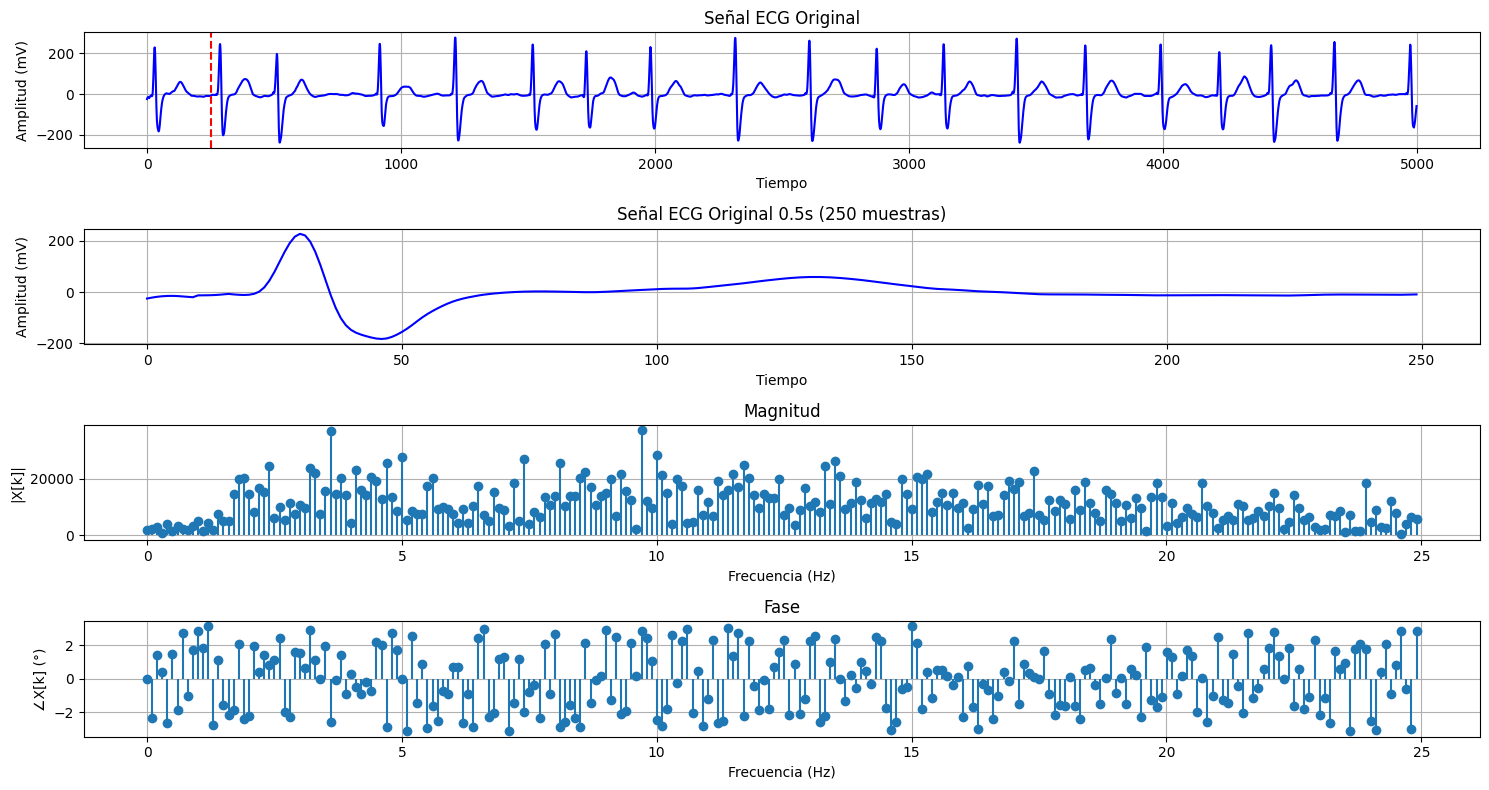

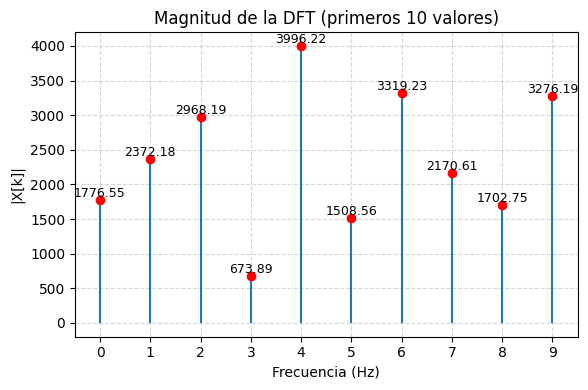

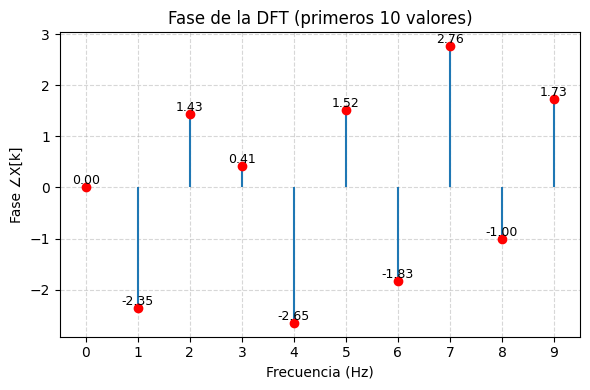

### Primeros valores del vector x[n]

timestamp,ecg_signal
0,-24.839000
1,-21.031000
2,-17.969000
3,-15.853000
4,-14.703000
5,-14.478000
6,-15.146000
7,-16.553000
8,-18.271000
9,-19.674000


### Primeros valores del vector X[K]

k,parte_real,parte_imaginaria
0,1776.546189,0.000000
1,-1670.455303,-1684.286322
2,414.085315,2939.161913
3,616.732199,271.615552
4,-3520.349047,-1891.284342
5,76.753289,1506.606233
6,-866.322871,-3204.179883
7,-2016.329391,803.722698
8,914.193972,-1436.529474
9,-504.996600,3237.040125


### Primeros valores del vector de magnitud

k,magnitud
0,1776.546189
1,2372.180712
2,2968.187898
3,673.894363
4,3996.224953
5,1508.560045
6,3319.229435
7,2170.611524
8,1702.752932
9,3276.194490


### Primeros valores del vector de fase

k,fase
0,0.000000
1,-2.352072
2,1.430832
3,0.414851
4,-2.648596
5,1.519896
6,-1.834856
7,2.762288
8,-1.004048
9,1.725555


### Valor potencia

92314968746.88507


### X[0] es la suma de todos los valores de la señal x(n)

1776.5461892100063


### suma de los valores x(n)

1776.5461892099995


In [2]:
'''CALCULO DFT'''
# Ruta archivo
ARCHIVO_PARQUET = './data/processed/parquet/AFIB/MUSE_20180111_155154_74000.parquet'
FS = 500  # Frecuencia de muestreo

# Cargar señal
df = pd.read_parquet(ARCHIVO_PARQUET)
x = df['ecg_signal'].values
N1 = len(x)
x_10 = x[:250]

# Calculo DFT
X = []
for k in range(N1):
    suma = 0
    for n in range(N1):
        suma += x[n] * np.exp(-2j * np.pi * k * n / N1)
    X.append(suma)
X = np.array(X)

# Guardar vector X[k] en CSV
df_X = pd.DataFrame({
    'k': np.arange(N1),
    'parte_real': X.real,
    'parte_imaginaria': X.imag
})
df_X.to_csv('vector_Xk_DFT.csv', index=False)

# Vector de frecuencia
frecuencias = np.arange(N1) * FS / N1

# Espectro
frecuencias_completas = frecuencias
magnitud = np.sqrt(X.real**2 + X.imag**2) + 1e-12
fase = np.arctan2(X.imag, X.real)
limite = int(0.5 * FS)
frecuencias_1s = frecuencias[:limite]
magnitud_1s = magnitud[:limite]
fase_1s = fase[:limite]

# DataFrame de magnitud
df_magnitud = pd.DataFrame({
    'k': np.arange(10),
    'magnitud': magnitud[:10]
})

# DataFrame de Fase
df_fase = pd.DataFrame({
    'k': np.arange(10),
    'fase': fase[:10]
})

# Potencia usando Parseval
potencia = np.sum(np.abs(X)**2)
v_0 = magnitud[0]
s_x = np.sum(x)

# Grafica resultados
plt.figure(figsize=(15, 8))
# Señal original completa
plt.subplot(4, 1, 1)
plt.plot(x, color='blue')
plt.axvline(x=250, color='red', linestyle='--', label='0.5 segundos')
plt.title('Señal ECG Original')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud (mV)')
plt.grid(True)

# Señal original a medio segundo (250 muestras)
plt.subplot(4, 1, 2)
plt.plot(range(250), x_10, color='blue')
plt.title('Señal ECG Original 0.5s (250 muestras)')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud (mV)')
plt.grid(True)

# GRAFICA MAGNITUD
plt.subplot(4, 1, 3)
plt.stem(frecuencias_1s, magnitud_1s, basefmt=" ")
plt.title('Magnitud')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X[k]|')
plt.grid(True)

# GRAFICA FASE
plt.subplot(4, 1, 4)
plt.stem(frecuencias_1s, fase_1s, basefmt=" ")
plt.title('Fase')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('∠X[k] (°)')
plt.grid(True)

plt.tight_layout()
plt.show()

# GRAFICO DE MAGNITUD DE 10 MUESTRAS
plt.figure(figsize=(6, 4)) 
plt.stem(range(10), magnitud[:10],  basefmt=" ", linefmt="C0-", markerfmt="ro")
for i, val in enumerate(magnitud[:10]):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(range(10))                
plt.xlim(-0.5, 9.5)               
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|X[k]|')
plt.title('Magnitud de la DFT (primeros 10 valores)')
plt.tight_layout()                
plt.show()

# GRAFICO DE FASE DE 10 MUESTRAS
plt.figure(figsize=(6, 4)) 
plt.stem(range(10), fase[:10],  basefmt=" ", linefmt="C0-", markerfmt="ro")
for i, val in enumerate(fase[:10]):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(range(10))                
plt.xlim(-0.5, 9.5)               
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Fase ∠X[k]')
plt.title('Fase de la DFT (primeros 10 valores)')
plt.tight_layout()                
plt.show()


# Archivo vector x[n]
display(Markdown("### Primeros valores del vector x[n]"))
display(df.head(10).style.hide(axis="index"))

# Archivo vector DFT x[k]
dy = pd.read_csv('./vector_Xk_DFT.csv')
display(Markdown("### Primeros valores del vector X[K]"))
display(dy.head(10).style.hide(axis="index"))

# Archivo de magnitud
display(Markdown("### Primeros valores del vector de magnitud"))
display(df_magnitud.head(10).style.hide(axis="index"))

# Archivo de fase
display(Markdown("### Primeros valores del vector de fase"))
display(df_fase.head(10).style.hide(axis="index"))

# Potencia
display(Markdown("### Valor potencia"))
print(potencia)

# Valor del coeficiente X[0] de fourier
display(Markdown("### X[0] es la suma de todos los valores de la señal x(n)"))
print(v_0)

# Suma del vector x(n)
display(Markdown("### suma de los valores x(n)"))
print(s_x)



#### **2.** Extracción de características usando la transformada discreta del coseno:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot \cos\left( \frac{\pi}{N} \left(n + \frac{1}{2} \right) k \right)
$$

Picos R: [ 286  510  861 1212 1518 1729 1981 2314 2606 2872 3135 3422 3693 3989
 4221 4424 4673]
Autocorrelación (21 coeficientes): [ 1.          0.82717629  0.65053913  0.47920469  0.31771742  0.16948142
  0.02774617 -0.10082187 -0.20906279 -0.29729594 -0.3634716  -0.40223151
 -0.41477917 -0.40294692 -0.35584461 -0.27258905 -0.15282169]


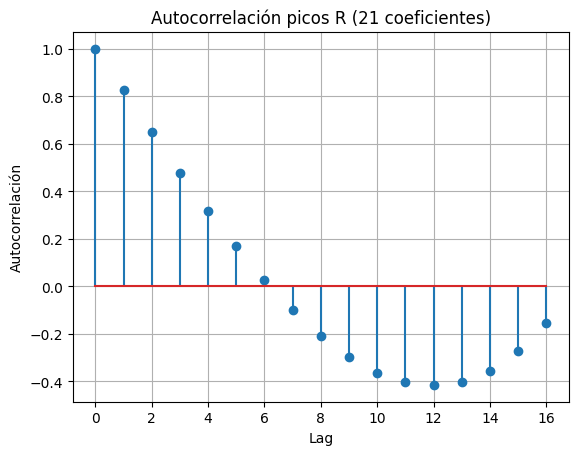

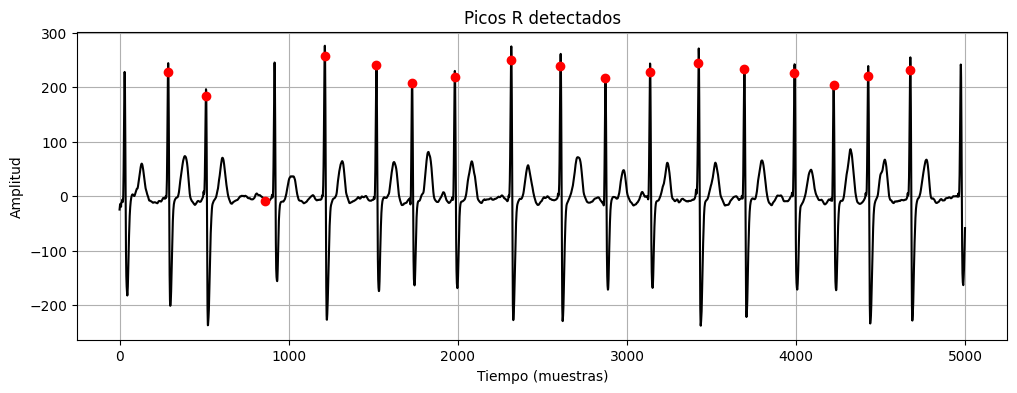

<Figure size 1500x800 with 0 Axes>

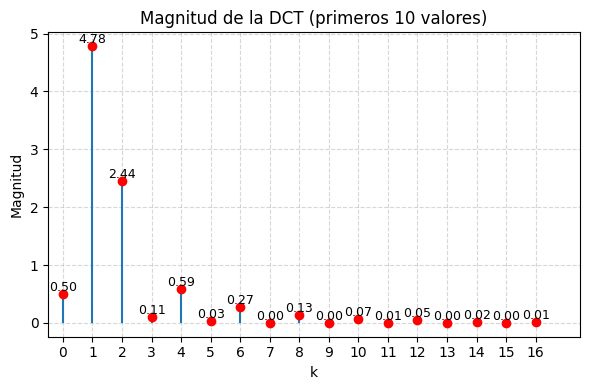

### Primeros valores del vector x[n]

timestamp,ecg_signal
0,-24.839000
1,-21.031000
2,-17.969000
3,-15.853000
4,-14.703000
5,-14.478000
6,-15.146000
7,-16.553000
8,-18.271000
9,-19.674000


### Primeros valores del vector X[K]

k,Coeficientes
0,0.500000
1,4.782410
2,2.443837
3,0.108520
4,0.593109
5,0.031650
6,0.266815
7,0.004446
8,0.132696
9,-0.002634


### Primeros valores del vector X[K] ortonormalizado

k,Coeficientes
0,0.500000
1,4.782410
2,2.443837
3,0.108520
4,0.593109
5,0.031650
6,0.266815
7,0.004446
8,0.132696
9,-0.002634


### Caracteristicas DCT

media,desviacion_std,potencia
0.530155,1.207255,29.554964


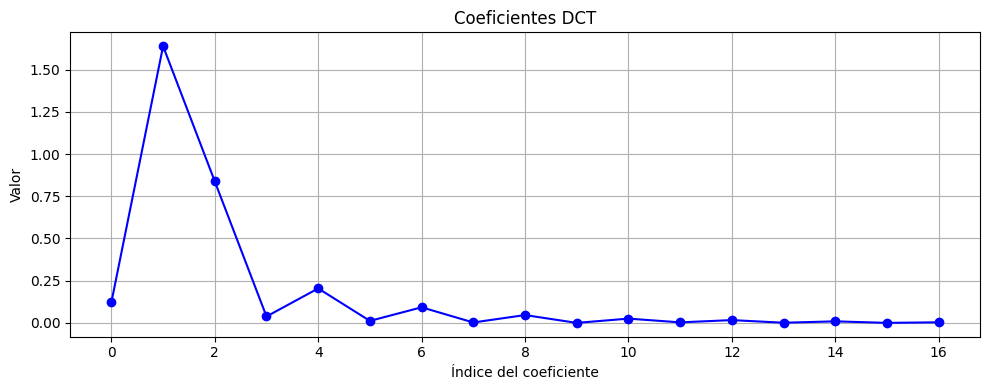

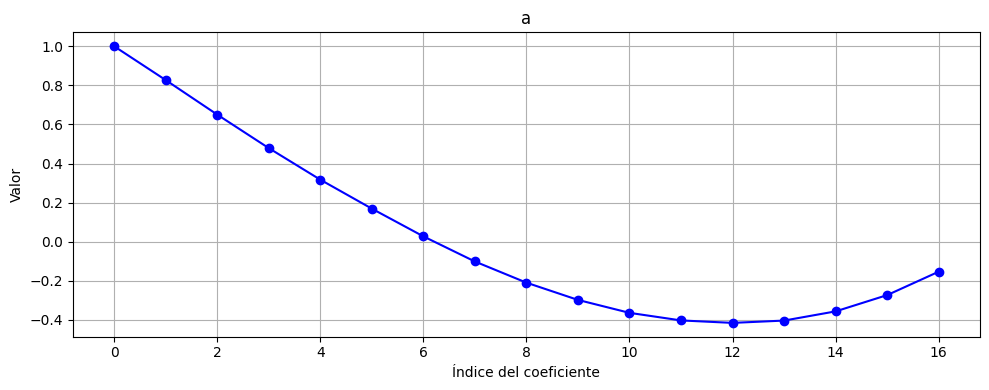

In [3]:
'''Calculo DCT'''

# Ruta
ARCHIVO_PARQUET = './data/processed/parquet/AFIB/MUSE_20180111_155154_74000.parquet'
FS = 500  # Frecuencia de muestreo en Hz

# Cargar señal
df = pd.read_parquet(ARCHIVO_PARQUET)
x = df['ecg_signal'].values
#N = len(x)
x_10 = x[:250]

# Neurokit (deteccion de picos R)
ecg_signals, ecg_info = nk.ecg_process(x, sampling_rate=FS)

# Indices de los picos R
r_peaks = ecg_info['ECG_R_Peaks']

# Autocorrelación
rr_centered = r_peaks - np.mean(r_peaks)
autocorr = np.correlate(rr_centered, rr_centered, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # solo lags positivos
autocorr = autocorr / autocorr[0]  # normalizar

# Primeros 21 coeficientes
autocorr_features = autocorr[:21]

# Resultados picos R y correlacion
print("Picos R:", r_peaks)
print("Autocorrelación (21 coeficientes):", autocorr_features)

# Grafica autocorrelacion
plt.stem(autocorr_features)
plt.title("Autocorrelación picos R (21 coeficientes)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.grid(True)
plt.show()

# Grafica deteccion de picos R
plt.figure(figsize=(12, 4))
plt.plot(x, label="ECG filtrado", color='black')
plt.scatter(r_peaks, x[r_peaks], color='red', label='Picos R', zorder=3)
plt.title("Picos R detectados")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
#plt.legend()
plt.grid(True)
plt.show()


# Calculo DCT
N = len(autocorr_features)
C = []
for k in range(N):
    suma = 0
    for n in range(N):
        suma += autocorr_features[n] * np.cos(np.pi * (n + 0.5) * k / N)
    C.append(suma)
C = np.array(C)

# Calculo DCT ortonormalizado
CO = dct(autocorr_features, type=2, norm='ortho')

# Vector X[k] ortonormalizado en CSV
df_CO = pd.DataFrame({
    'k': np.arange(N),
    'Coeficientes': C
})
df_CO.to_csv('vector_Xk_DCT_orto.csv', index=False)

# Vector X[k] en CSV
df_C = pd.DataFrame({
    'k': np.arange(N),
    'Coeficientes': C
})
df_C.to_csv('vector_Xk_DCT.csv', index=False)

# Magnitud
magnitudes = np.abs(C)

# Características
media = np.mean(C)
desviacion = np.std(C)
potencia = np.sum(magnitudes**2)

# DataFrame características
caracteristicas = {
    'media': [media],
    'desviacion_std': [desviacion],
    'potencia': [potencia],
}

df_feat = pd.DataFrame(caracteristicas)

# Grafica resultados
plt.figure(figsize=(15, 8))


# GRAFICO DE MAGNITUD
plt.figure(figsize=(6, 4)) 
plt.stem(range(N), magnitudes[:],  basefmt=" ", linefmt="C0-", markerfmt="ro")
for i, val in enumerate(magnitudes[:]):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(range(N))                
plt.xlim(-0.5, 17.5)               
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('k')
plt.ylabel('Magnitud')
plt.title('Magnitud de la DCT (primeros 10 valores)')
plt.tight_layout()                
plt.show()


# Archivo vector x[n]
display(Markdown("### Primeros valores del vector x[n]"))
display(df.head(10).style.hide(axis="index"))

# Cargar archivo vector DFT x[k]
dy = pd.read_csv('./vector_Xk_DCT.csv')
display(Markdown("### Primeros valores del vector X[K]"))
display(dy.head(10).style.hide(axis="index"))

# Cargar archivo vector DFT x[k] ortnonormalizado
dyO = pd.read_csv('./vector_Xk_DCT_orto.csv')
display(Markdown("### Primeros valores del vector X[K] ortonormalizado"))
display(dyO.head(10).style.hide(axis="index"))

# CARACTERISTICAS
display(Markdown("### Caracteristicas DCT"))
display(df_feat.style.hide(axis="index"))

plt.figure(figsize=(10, 4))
plt.plot(CO, marker='o', linestyle='-', color='blue')
plt.title('Coeficientes DCT')
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(autocorr_features, marker='o', linestyle='-', color='blue')
plt.title('a')
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
N1=len(x)
potencia = 1/N1*(np.sum(np.abs(X)**2))
m = np.sum(np.abs(autocorr_features)**2)
#----------------
potencia_2 = np.sum(CO**2)
potencia_3 = (np.sum(np.abs(x)**2))

print(potencia)
print(m)
print(potencia_2)
print(potencia_3)

18466687.086794373
3.4623486695212846
3.462348669521282
18466687.086794425


### **3.** Coeficientes cepstrales de Mel (MFCC) 

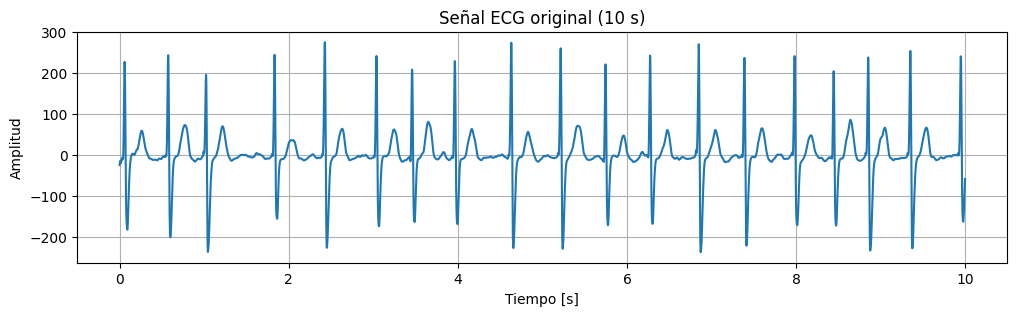

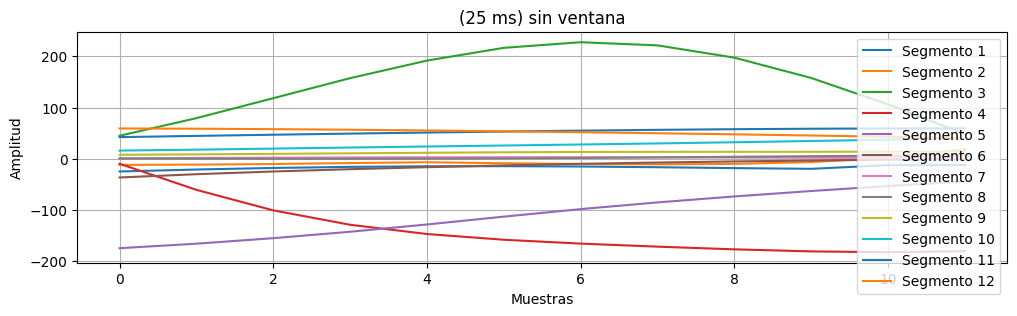

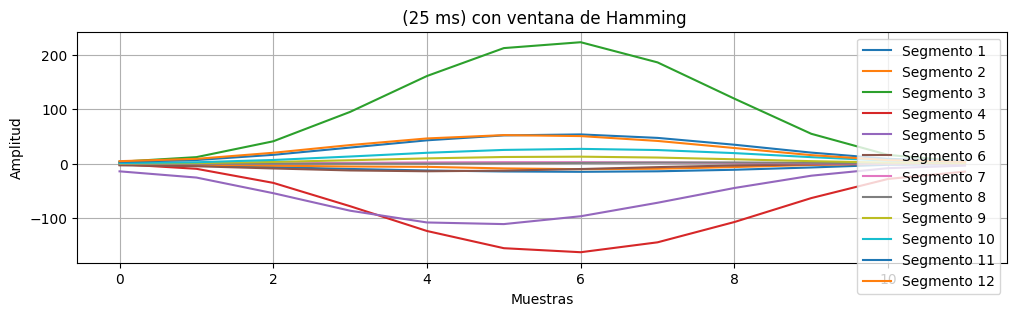

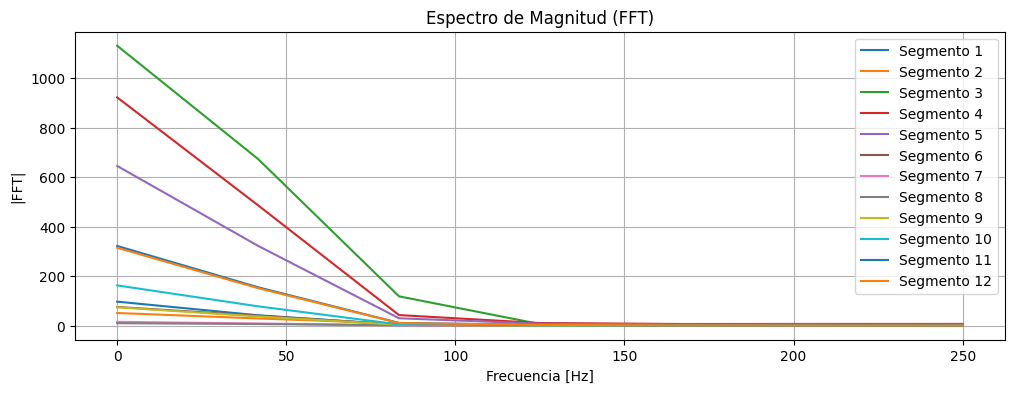

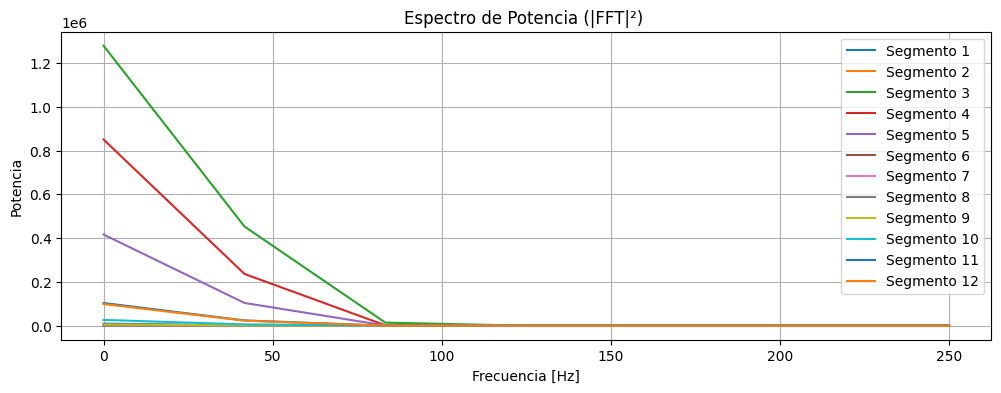

C:\Users\fabio\AppData\Local\Temp\ipykernel_6456\673203264.py:106: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_filterbank = librosa.filters.mel(sr=FS, n_fft=window_size, n_mels=n_mels)


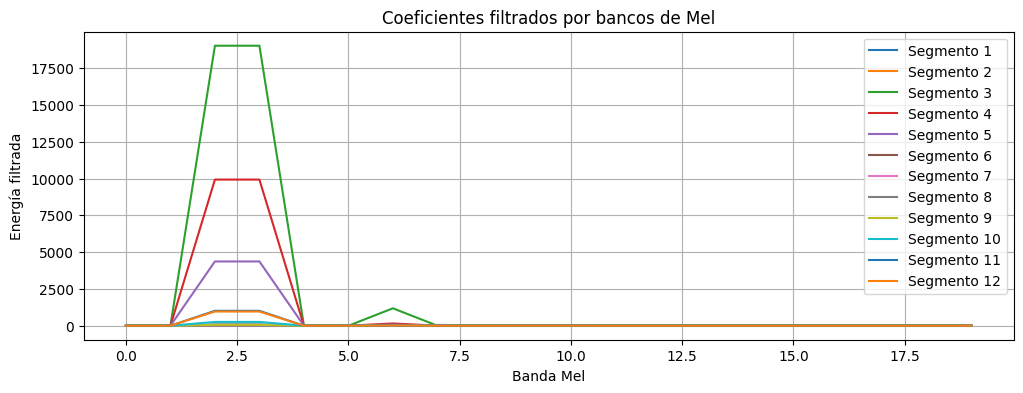

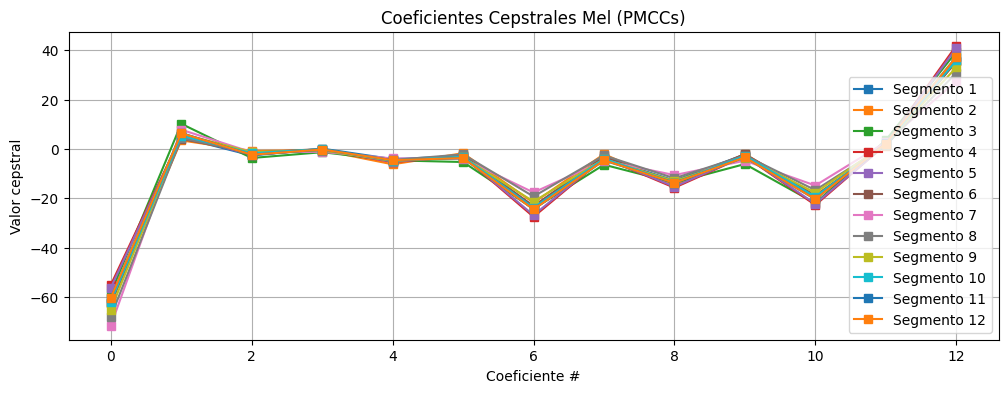

             coef_1     coef_2    coef_3    coef_4    coef_5    coef_6  \
segmento                                                                 
0        -62.197712   4.601256 -2.672183  0.111941 -4.135366 -2.906806   
1        -62.654954   3.442750 -0.804914 -0.515491 -6.252432 -1.751878   
2        -58.453543  10.183249 -3.679376 -1.337522 -4.634135 -5.314035   
3        -55.141959   5.318430 -2.349753 -0.332097 -5.362025 -3.034079   
4        -56.261748   5.136422 -2.364554 -0.275439 -5.204000 -2.962222   
5        -62.441371   4.048026 -1.519056 -0.046262 -4.990010 -2.455123   
6        -71.662461   7.772505 -1.325646 -1.158720 -3.888340 -3.958701   
7        -67.990183   4.358602 -1.590012 -0.649899 -4.523455 -2.219842   
8        -65.253553   6.123509 -1.306482 -0.528489 -4.883867 -3.390207   
9        -61.900440   5.368992 -1.724682 -0.123668 -4.710676 -3.212297   
10       -60.386645   6.451682 -2.406001 -0.269025 -4.542218 -3.775065   
11       -60.384444   6.348769 -2.3560

In [16]:

# --------------------------
# Parámetros y carga de señal
# --------------------------
ARCHIVO_PARQUET = './data/processed/parquet/AFIB/MUSE_20180111_155154_74000.parquet'
FS = 500  # Frecuencia de muestreo en Hz

# Leer archivo Parquet
df = pd.read_parquet(ARCHIVO_PARQUET)
ecg_signal = df.iloc[:, 1].values
t = np.arange(len(ecg_signal)) / FS

# --------------------------
# Gráfica de la señal original
# --------------------------
plt.figure(figsize=(12, 3))
plt.plot(t, ecg_signal)
plt.title('Señal ECG original (10 s)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# --------------------------
# Segmentación de la señal
# --------------------------
window_size = int(0.025 * FS)  # 25 ms → 12 muestras
step_size = window_size  # sin solapamiento

segments = [
    ecg_signal[i:i + window_size]
    for i in range(0, len(ecg_signal) - window_size + 1, step_size)
]

# --------------------------
# Graficar primeros segmentos sin ventana
# --------------------------
plt.figure(figsize=(12, 3))
for i in range(12):
    plt.plot(segments[i], label=f'Segmento {i+1}')
plt.title('(25 ms) sin ventana')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# Aplicar ventana de Hamming
# --------------------------
hamming = np.hamming(window_size)
segments_windowed = [seg * hamming for seg in segments]

# --------------------------
# Graficar primeros segmentos con ventana
# --------------------------
plt.figure(figsize=(12, 3))
for i in range(12):
    plt.plot(segments_windowed[i], label=f'Segmento {i+1}')
plt.title(' (25 ms) con ventana de Hamming')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# FFT por segmento con ventana
# --------------------------
fft_segments = [np.fft.rfft(seg) for seg in segments_windowed]
frequencies = np.fft.rfftfreq(window_size, d=1/FS)

# Magnitud y potencia
mag_spectra = [np.abs(fft) for fft in fft_segments]
power_spectra = [np.abs(fft)**2 for fft in fft_segments]

# --------------------------
# Graficar espectro de magnitud (primeros 5)
# --------------------------
plt.figure(figsize=(12, 4))
for i in range(12):
    plt.plot(frequencies, mag_spectra[i], label=f'Segmento {i+1}')
plt.title('Espectro de Magnitud (FFT)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|FFT|')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# Graficar espectro de potencia (primeros 5)
# --------------------------
plt.figure(figsize=(12, 4))
for i in range(12):
    plt.plot(frequencies, power_spectra[i], label=f'Segmento {i+1}')
plt.title('Espectro de Potencia (|FFT|²) ')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# Mel Filtering a espectros de magnitud
# --------------------------
n_mels = 20  # número de filtros mel
mel_filterbank = librosa.filters.mel(sr=FS, n_fft=window_size, n_mels=n_mels)

# Aplicar filtro mel a los primeros 5 espectros de potencia
mel_spectra = [np.dot(mel_filterbank, power) for power in power_spectra[:12]]


# --------------------------
# Graficar bancos de Mel de los primeros 5 segmentos
# --------------------------
plt.figure(figsize=(12, 4))
for i in range(12):
    plt.plot(mel_spectra[i], label=f'Segmento {i+1}')
plt.title('Coeficientes filtrados por bancos de Mel')
plt.xlabel('Banda Mel')
plt.ylabel('Energía filtrada')
plt.legend()
plt.grid(True)
plt.show()


# --------------------------
# Cálculo de coeficientes cepstrales (PMCCs) desde Mel filtrado de POTENCIA
# --------------------------
n_mfcc = 13
# Aplicar logaritmo para obtener escala logarítmica antes de la DCT
log_mel_spectra = [np.log(mel + 1e-10) for mel in mel_spectra]  # se agrega un epsilon para evitar log(0)

# Calcular DCT de los espectros log-Mel para obtener coeficientes cepstrales
pmccs = [dct(log_mel, type=2, norm='ortho')[:n_mfcc] for log_mel in log_mel_spectra]

# --------------------------
# Graficar coeficientes cepstrales (PMCCs)
# --------------------------
plt.figure(figsize=(12, 4))
for i in range(12):
    plt.plot(pmccs[i], marker='s', label=f'Segmento {i+1}')
plt.title('Coeficientes Cepstrales Mel (PMCCs)')
plt.xlabel('Coeficiente #')
plt.ylabel('Valor cepstral')
plt.legend()
plt.grid(True)
plt.show()

# Crear DataFrame con los PMCCs
column_names = [f'coef_{i+1}' for i in range(n_mfcc)]
df_pmccs = pd.DataFrame(pmccs, columns=column_names)
df_pmccs.index.name = 'segmento'

# Mostrar la tabla
print(df_pmccs)



### **Comparación de características entre grupos**
#### **1.** Comparar grupos estadistica descriptiva:
##### **1.1** Calculo DCT

In [115]:
# Lista de arritmias
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB', 'ST', 'SVT']
base_path = './data/processed/parquet'

# Almacenar los promedios DCT por arritmia
resultados_dct_arritmia = {}

# Procesar cada arritmia
for arritmia in arritmias:
    arritmia_path = os.path.join(base_path, arritmia)
    archivos = [f for f in os.listdir(arritmia_path) if f.endswith('.parquet')]
    dct_por_senal = []

    for archivo in archivos:
        # Leer el archivo
        df = pd.read_parquet(os.path.join(arritmia_path, archivo))

        # Suponemos que la señal está en una columna llamada 'ecg'
        if 'ecg_signal' not in df.columns:
            continue  # O ajusta al nombre correcto

        ecg_signal = df['ecg_signal'].values

        try:
            # Procesamiento ECG
            _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=500)  # Ajusta el sampling rate si es diferente

            # Extraer las posiciones de los picos R
            r_locs = np.where(rpeaks['ECG_R_Peaks'])[0]

            if len(r_locs) < 2:
                continue  # No se puede calcular autocorrelación con menos de 2 picos

            # Calcular la autocorrelación del tren de impulsos de picos R
            train = np.zeros(len(ecg_signal))
            train[r_locs] = 1
            autocorr = correlate(train, train, mode='full')
            autocorr_centered = autocorr[len(autocorr)//2:]

            # Tomar los primeros 21 coeficientes
            autocorr_21 = autocorr_centered[:21]

            # Calcular la DCT
            dct_result = dct(autocorr_21, norm='ortho')

            # Guardar resultado
            dct_por_senal.append(dct_result)

        except Exception as e:
            print(f"Error procesando {archivo} en {arritmia}: {e}")

    # Calcular el promedio de DCTs de todas las señales de esta arritmia
    if dct_por_senal:
        promedio_dct = np.mean(dct_por_senal, axis=0)
        potencia_dct = np.sum(promedio_dct**2)

        resultados_dct_arritmia[arritmia] = {
            'promedio_dct': promedio_dct,
            'potencia_dct': potencia_dct
        }
    else:
        resultados_dct_arritmia[arritmia] = {
            'promedio_dct': None,
            'potencia_dct': None
        }
# Mostrar los resultados
for arritmia, resultados in resultados_dct_arritmia.items():
    print(f"\nArritmia: {arritmia}")
    if resultados['promedio_dct'] is not None:
        print(f"Promedio DCT: {resultados['promedio_dct']}")
        print(f"Potencia del promedio DCT: {resultados['potencia_dct']}")
    else:
        print("No se pudieron calcular los coeficientes DCT.")






Arritmia: SR
Promedio DCT: [1.75978175e+01 1.79293279e+01 5.94964872e+00 5.67680546e-01
 6.38661624e-01 8.08861692e-01 3.72332503e-01 1.92617166e-01
 1.97802413e-01 1.86414530e-01 1.24931730e-01 8.08742522e-02
 7.94012859e-02 6.96320170e-02 5.27610570e-02 3.95853561e-02
 2.86646209e-02 2.66154780e-02 2.17020688e-02 1.02413241e-02
 3.27722900e-03]
Potencia del promedio DCT: 668.2160858106824

Arritmia: AFIB
Promedio DCT: [2.84358492e+01 2.18913789e+01 3.69592289e+00 1.17847827e+00
 8.24207861e-01 6.30470768e-01 3.22322014e-01 2.92640701e-01
 1.76576121e-01 1.74763062e-01 1.10672360e-01 1.05249881e-01
 7.10061844e-02 7.14586808e-02 4.47559458e-02 4.67413150e-02
 2.79239475e-02 2.85696535e-02 1.52262624e-02 1.39904743e-02
 4.41418491e-03]
Potencia del promedio DCT: 1304.2464182340682

Arritmia: AF
Promedio DCT: [4.01925245e+01 2.42253634e+01 2.16318642e+00 1.93874449e+00
 5.19793565e-01 7.64482667e-01 2.33954685e-01 3.58290275e-01
 1.28875194e-01 2.13646689e-01 7.79953598e-02 1.28545499e

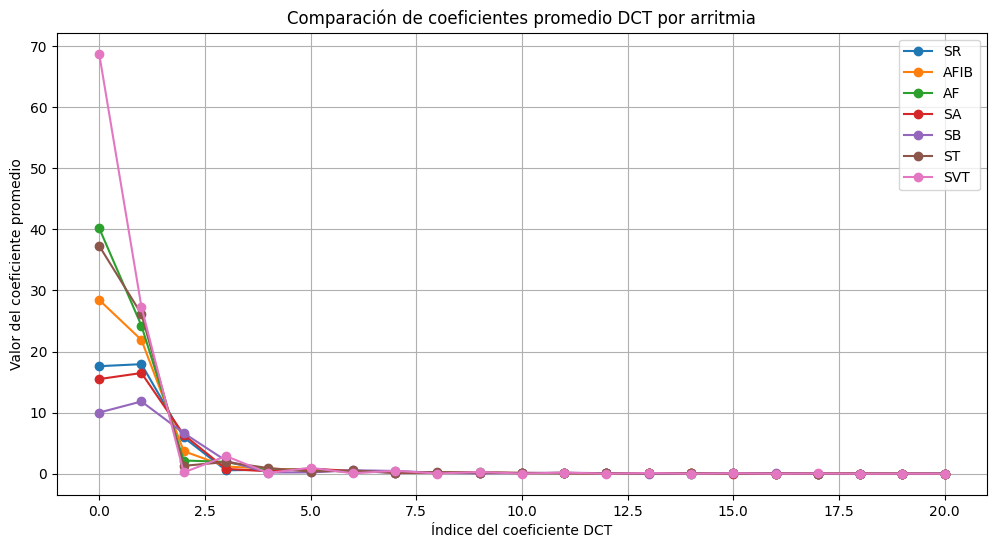

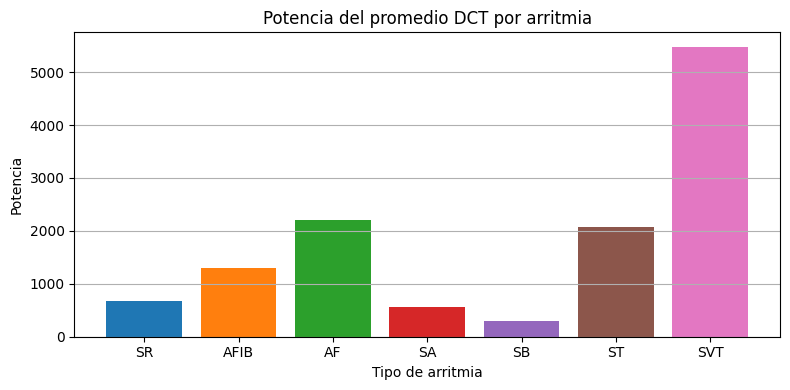

In [16]:
plt.figure(figsize=(12, 6))

for arritmia, resultados in resultados_dct_arritmia.items():
    promedio_dct = resultados['promedio_dct']
    if promedio_dct is not None:
        plt.plot(np.arange(len(promedio_dct)), promedio_dct, marker='o', label=arritmia)

plt.title('Comparación de coeficientes promedio DCT por arritmia')
plt.xlabel('Índice del coeficiente DCT')
plt.ylabel('Valor del coeficiente promedio')
plt.legend()
plt.grid(True)
plt.show()

# Preparar datos
etiquetas = []
potencias = []

for arritmia, resultados in resultados_dct_arritmia.items():
    if resultados['potencia_dct'] is not None:
        etiquetas.append(arritmia)
        potencias.append(resultados['potencia_dct'])

# Lista de colores (tantos como arritmias)
colores = plt.cm.tab10.colors  # Puedes cambiar por 'Set3', 'Dark2', etc.
colores_barras = colores[:len(etiquetas)]

# Crear gráfico
plt.figure(figsize=(8, 4))
plt.bar(etiquetas, potencias, color=colores_barras)

plt.title('Potencia del promedio DCT por arritmia')
plt.xlabel('Tipo de arritmia')
plt.ylabel('Potencia')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### **1.2** Calculo FDT

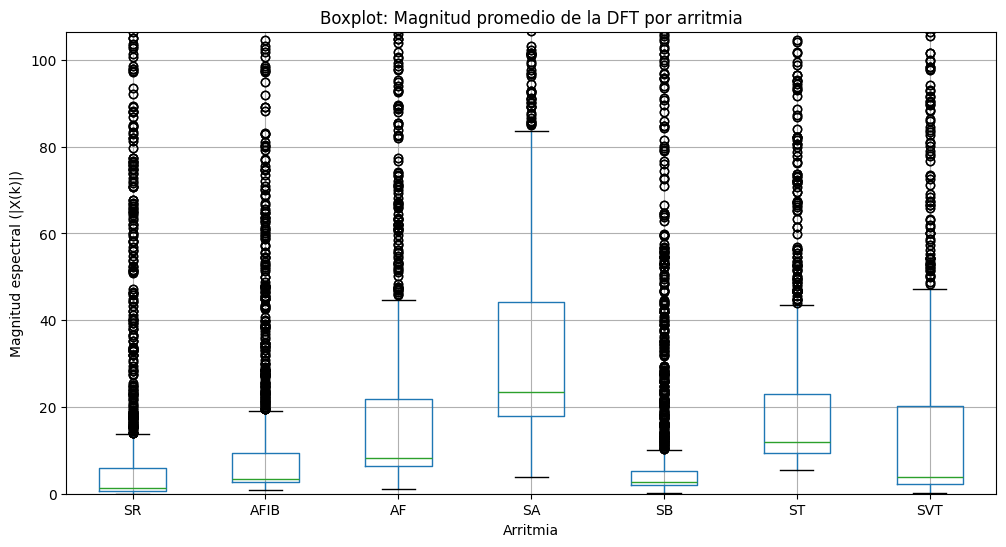

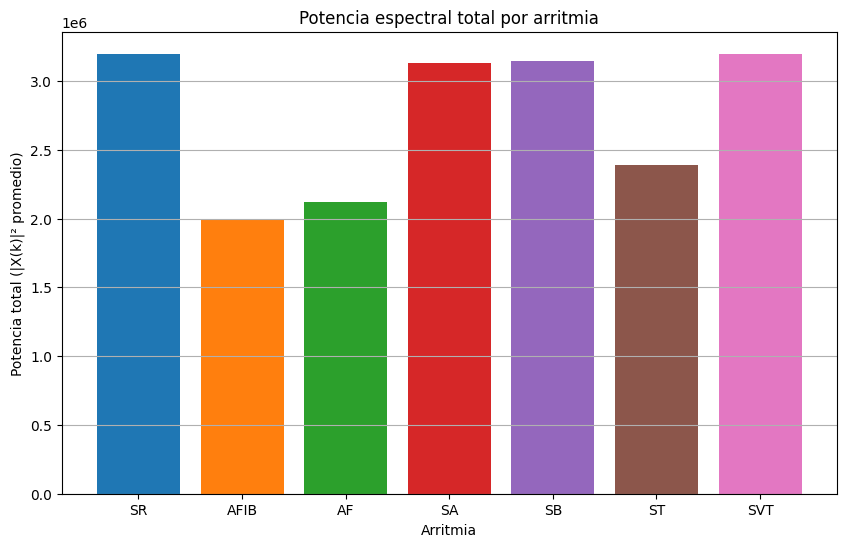

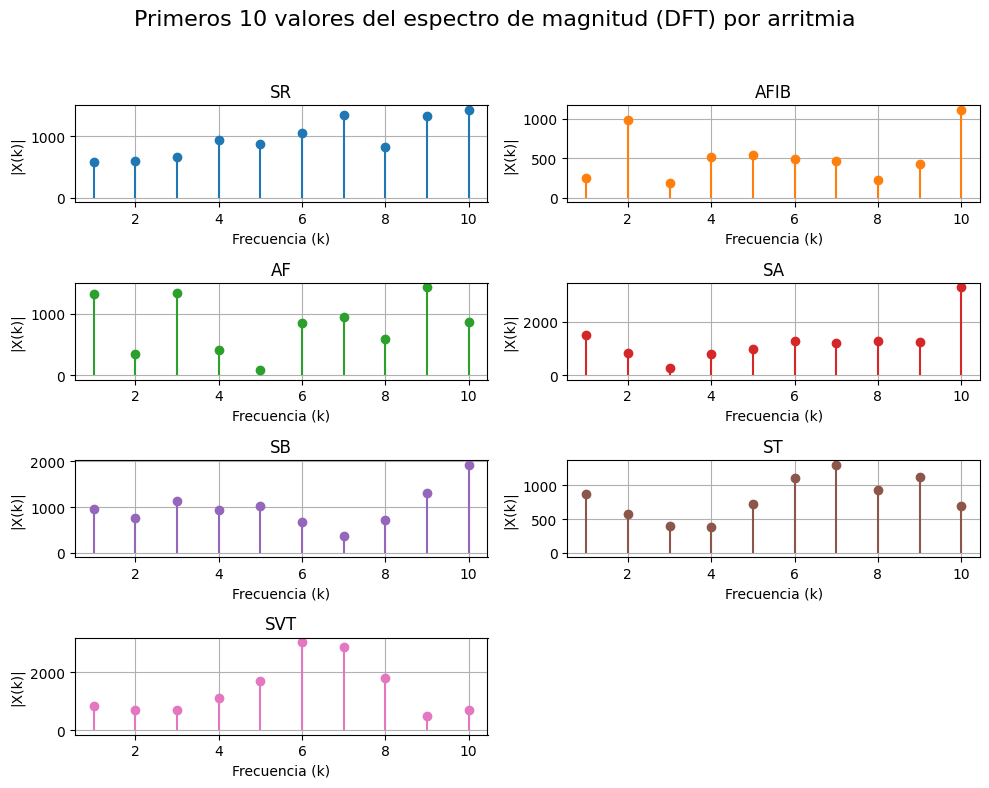

Potencia espectral (DFT) por arritmia:
SR: 3196580.4875
AFIB: 1999283.7794
AF: 2120502.4943
SA: 3131672.4783
SB: 3143617.9835
ST: 2387699.9134
SVT: 3198552.4283


In [184]:
# Parámetros
Fs = 500
duracion = 10
N = Fs * duracion  # 5000 muestras

# Ruta y arritmias
base_path = './data/processed/parquet'
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB', 'ST', 'SVT']

# Diccionarios
magnitudes_dft = {}
potencias_frecuencia = {}

# Colores por arritmia
colores = {
    'SR': '#1f77b4',
    'AFIB': '#ff7f0e',
    'AF': '#2ca02c',
    'SA': '#d62728',
    'SB': '#9467bd',
    'ST': '#8c564b',
    'SVT': '#e377c2'
}

# Procesar cada arritmia
for arr in arritmias:
    carpeta = os.path.join(base_path, arr)
    archivos = glob(os.path.join(carpeta, '*.parquet'))
    
    señales_arr = []

    for archivo in archivos:
        df = pd.read_parquet(archivo)
        señal = df['ecg_signal'].dropna().values
        if len(señal) == N - 1:
            señales_arr.append(señal)

    if señales_arr:
        señales_arr = np.array(señales_arr)
        promedio = np.mean(señales_arr, axis=0)

        # Aplicar DFT al promedio
        Xk = np.fft.fft(promedio)
        magnitud = np.abs(Xk)
        
        # Guardar magnitud para el boxplot
        magnitudes_dft[arr] = magnitud
        
        # Potencia espectral total
        potencia = np.sum(magnitud**2) / N
        potencias_frecuencia[arr] = potencia

# ---------- Boxplot del espectro ----------
df_dft = pd.DataFrame(magnitudes_dft)

plt.figure(figsize=(12, 6))
df_dft.boxplot()
plt.title('Boxplot: Magnitud promedio de la DFT por arritmia')
plt.xlabel('Arritmia')
plt.ylabel('Magnitud espectral (|X(k)|)')
plt.grid(True)
limite_superior = np.percentile(df_dft.values, 85)
plt.ylim(0, limite_superior)
plt.show()

# ---------- Barplot de potencia espectral ----------
plt.figure(figsize=(10, 6))
colores_barra = [colores[arr] for arr in potencias_frecuencia.keys()]
plt.bar(potencias_frecuencia.keys(), potencias_frecuencia.values(), color=colores_barra)
plt.title('Potencia espectral total por arritmia')
plt.xlabel('Arritmia')
plt.ylabel('Potencia total (|X(k)|² promedio)')
plt.grid(True, axis='y')
plt.show()

# ---------- Subplots: primeros 10 valores de la DFT por arritmia ----------
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 8))
axs = axs.flatten()  # Convertimos en lista para iterar fácilmente

for i, arr in enumerate(arritmias):
    if arr in magnitudes_dft:
        magnitud = magnitudes_dft[arr][1:11]
        marcador = axs[i].stem(range(1,11), magnitud,  basefmt=" ")
        axs[i].set_title(arr)
        axs[i].set_xlabel('Frecuencia (k)')
        axs[i].set_ylabel('|X(k)|')
        axs[i].grid(True)
        
        # Colorear
        plt.setp(marcador.markerline, color=colores[arr])
        plt.setp(marcador.stemlines, color=colores[arr])
        plt.setp(marcador.baseline, visible=False)

# Eliminar subplot extra si sobran (por ejemplo, si hay solo 7 arritmias y hay 8 subplots)
for j in range(len(arritmias), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('Primeros 10 valores del espectro de magnitud (DFT) por arritmia', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---------- Mostrar potencias en consola ----------
print("Potencia espectral (DFT) por arritmia:")
for arr, p in potencias_frecuencia.items():
    print(f"{arr}: {p:.4f}")



##### **1.3** Calculo MFCC

In [ ]:

# ---------------------------------------------------
# IMPORTACIONES Y FIX PARA LIBROSA
# ---------------------------------------------------

np.complex = complex  # solución temporal para librosa

# ---------------------------------------------------
# PARÁMETROS GLOBALES
# ---------------------------------------------------
FS          = 500                  
WIN_MS      = 25                   
window_size = int(WIN_MS * 1e-3 * FS)
step_size   = window_size         
N_MELS      = 10                   
N_MFCC      = 10                   
BASE_PATH   = './data/processed/parquet'
ARRITMIAS   = ['SR', 'AFIB', 'AF', 'SA', 'SB', 'ST', 'SVT']

# ---------------------------------------------------
# FUNCIÓN: PROCESAR UNA SEÑAL → MATRIZ (segmentos × N_MFCC)
# ---------------------------------------------------
def extraer_pmccs(file_path: str) -> np.ndarray:
    """Lee un .parquet ECG, segmenta, calcula PMCCs y devuelve
    un array shape=(n_segmentos, N_MFCC)."""
    df = pd.read_parquet(file_path)
    
   
    ecg = df.iloc[:, 1].values
    
    # Segmentación
    segs = [
        ecg[i:i + window_size]
        for i in range(0, len(ecg) - window_size + 1, step_size)
    ]
    
    # Ventana de Hamming
    hamming = np.hamming(window_size)
    segs_win = [s * hamming for s in segs]
    
    # FFT y potencia
    power_specs = [np.abs(np.fft.rfft(s))**2 for s in segs_win]
    
    # Filtro Mel
    mel_fb = librosa.filters.mel(sr=FS, n_fft=window_size, n_mels=N_MELS)
    mel_specs = [mel_fb @ p for p in power_specs]
    
    # PMCCs: log + DCT
    log_mel   = [np.log(m + 1e-10) for m in mel_specs]
    pmccs     = [dct(m, type=2, norm='ortho')[:N_MFCC] for m in log_mel]
    
    return np.array(pmccs)

# ---------------------------------------------------
# RECORRER TODAS LAS ARRITMIAS
# ---------------------------------------------------
pmccs_por_arritmia = {}  

for arr in ARRITMIAS:
    carpeta = os.path.join(BASE_PATH, arr)
    if not os.path.isdir(carpeta):
        print(f'⚠️ Carpeta no encontrada: {carpeta}')
        continue
    
    print(f'Procesando arritmia: {arr}')
    todos = []
    
    for fichero in os.listdir(carpeta):
        if fichero.endswith('.parquet'):
            ruta = os.path.join(carpeta, fichero)
            try:
                todos.append(extraer_pmccs(ruta))
            except Exception as e:
                print(f'  Error con {fichero}: {e}')
    
    if todos:                      # concatenar todos los segmentos
        pmccs_por_arritmia[arr] = np.vstack(todos)
    else:
        print(f'  ⚠️ Sin archivos .parquet válidos para {arr}')

# ---------------------------------------------------
# TABLA DE PROMEDIOS POR ARRITMIA
# ---------------------------------------------------
prom_df = pd.DataFrame({
    arr: v.mean(axis=0) for arr, v in pmccs_por_arritmia.items()
}).T
prom_df.columns = [f'coef_{i+1}' for i in range(N_MFCC)]
prom_df.index.name = 'arritmia'

print('\nPROMEDIO DE PMCCs POR ARRITMIA')
print(prom_df)



Procesando arritmia: SR
Procesando arritmia: AFIB
Procesando arritmia: AF
Procesando arritmia: SA
Procesando arritmia: SB
Procesando arritmia: ST
Procesando arritmia: SVT

PROMEDIO DE PMCCs POR ARRITMIA
            coef_1    coef_2    coef_3    coef_4    coef_5        coef_6  \
arritmia                                                                   
SR       -6.456958  9.605546  2.766483  1.190781 -0.685255 -4.956730e-07   
AFIB     -6.931845  9.476730  2.798136  1.005308 -0.810508 -5.343570e-07   
AF       -4.743255  9.466088  2.811822  1.176215 -0.694504 -1.875121e-07   
SA       -7.375162  9.596002  2.781684  1.077691 -0.762667 -5.543989e-07   
SB       -9.594099  9.641732  2.749336  0.883351 -0.878064 -2.330560e-06   
ST       -3.469132  9.492192  2.828735  1.285359 -0.644801  2.685889e-07   
SVT      -4.921762  8.988869  2.590556  1.277646 -0.545545 -1.281243e-07   

            coef_7    coef_8    coef_9   coef_10  
arritmia                                          
SR       -

C:\Users\fabio\AppData\Local\Temp\ipykernel_20644\598242650.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data[:, j] for j in range(N_MFCC)], labels=labels)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20644\598242650.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data[:, j] for j in range(N_MFCC)], labels=labels)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20644\598242650.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data[:, j] for j in range(N_MFCC)], labels=labels)
C:\Users\fabio\AppData\Local\Temp\ipykernel_20644\598242650.py:20: MatplotlibDeprecationWarning: 

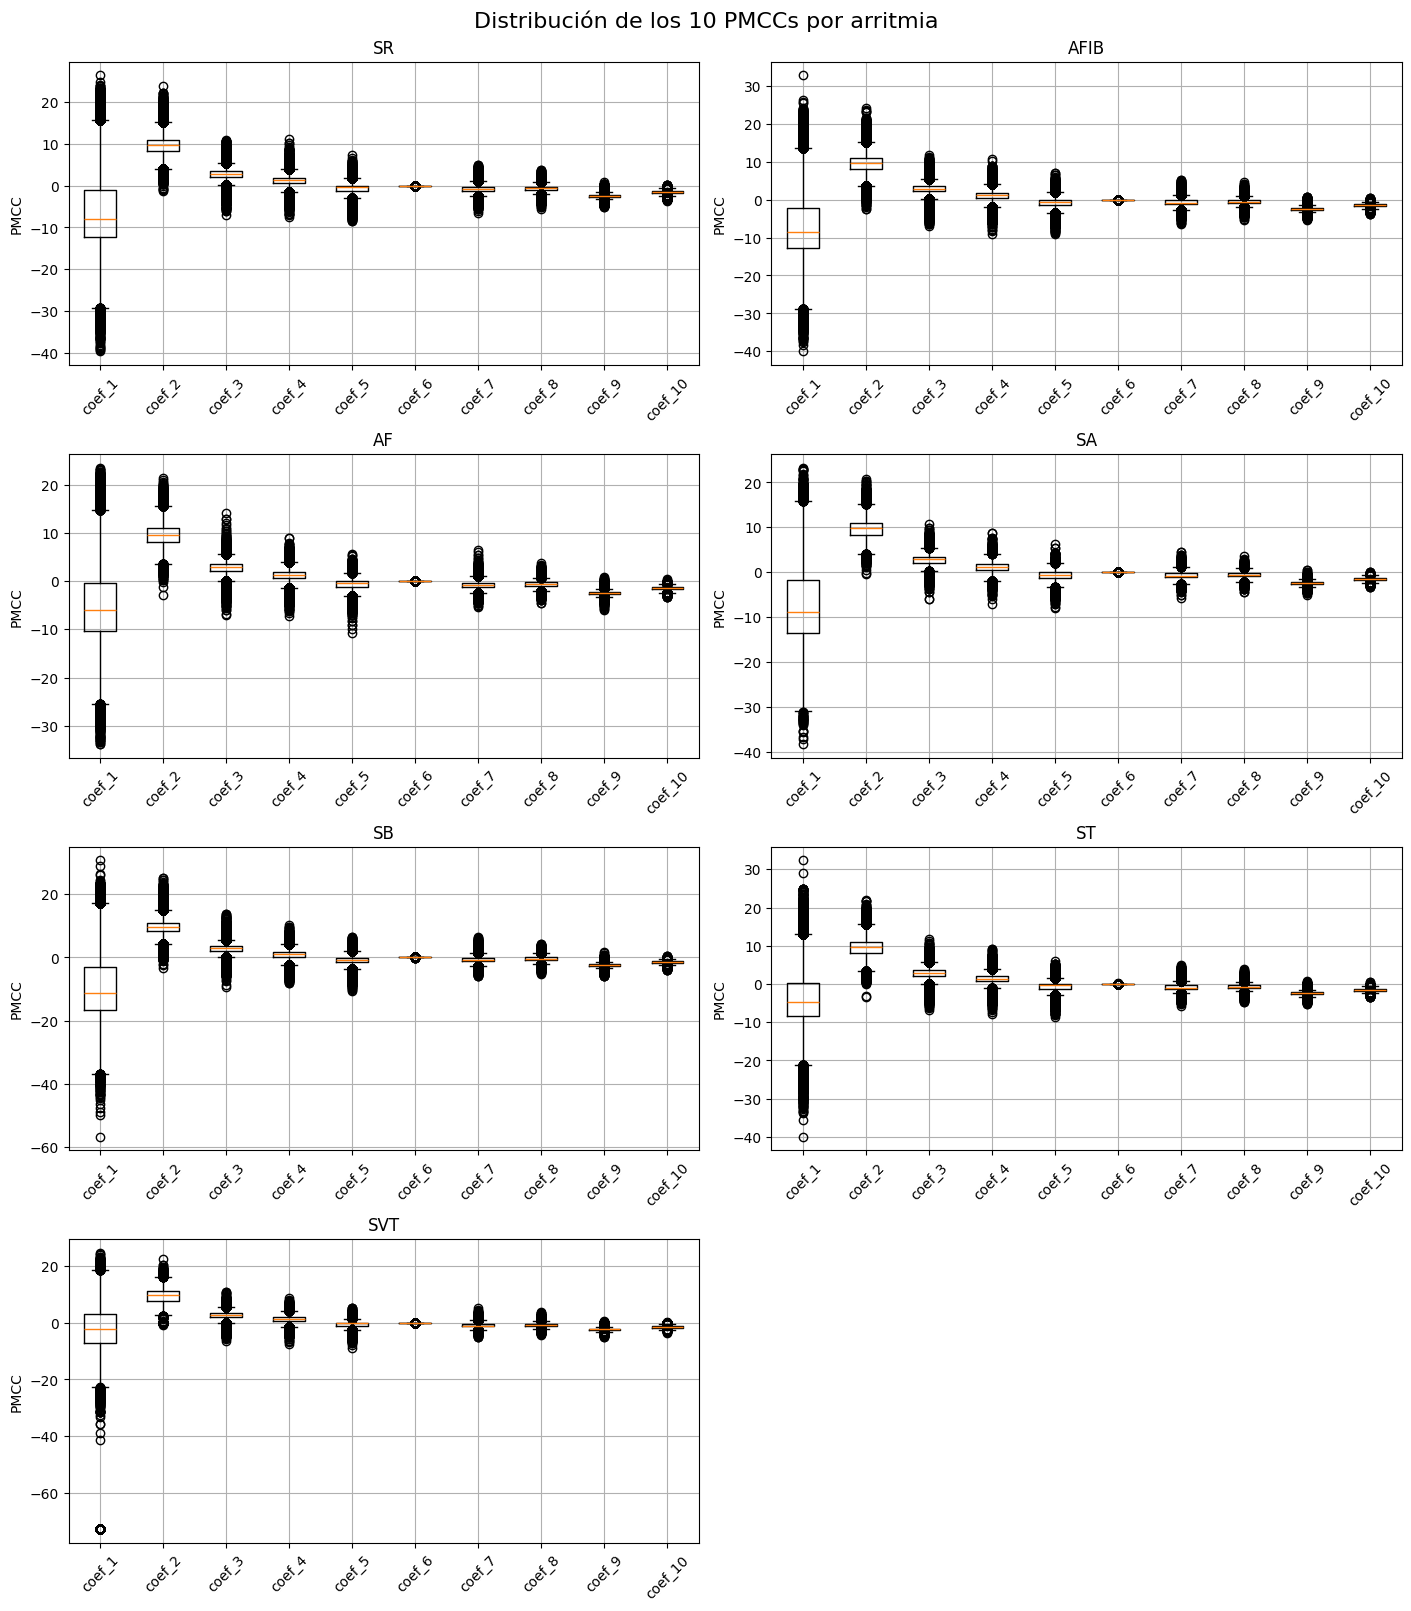

In [182]:

# Etiquetas de los 10 coeficientes
labels = [f'coef_{i+1}' for i in range(N_MFCC)]

# Número total de arritmias
num_arr = len(pmccs_por_arritmia)

# Calcular número de filas para un layout de 2 columnas
n_cols = 2
n_rows = math.ceil(num_arr / n_cols)

# Crear figura con subplots organizados en 2 columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), constrained_layout=True)

# Aplanar los ejes si están en 2D
axes = axes.flatten()

# Iterar sobre cada arritmia y graficar sus coeficientes
for i, (arr, data) in enumerate(pmccs_por_arritmia.items()):
    ax = axes[i]
    ax.boxplot([data[:, j] for j in range(N_MFCC)], labels=labels)
    ax.set_title(f'{arr}', fontsize=12)
    ax.set_ylabel('PMCC')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# Ocultar ejes no usados si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Título general
plt.suptitle('Distribución de los 10 PMCCs por arritmia', fontsize=16)
plt.show()






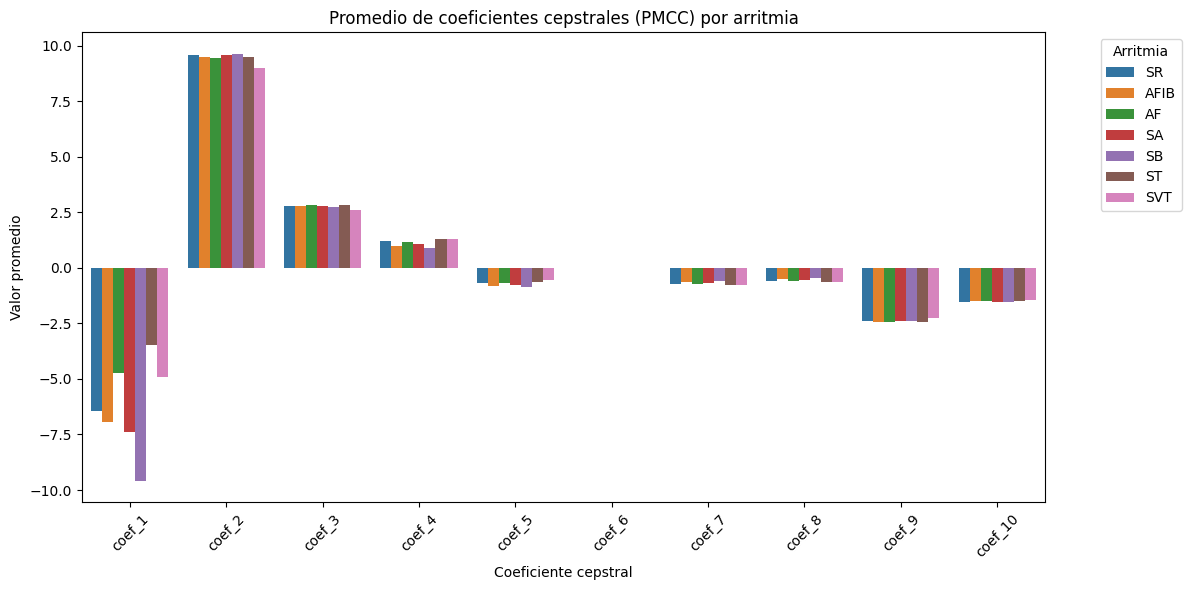

In [ ]:

prom_df_t = prom_df.reset_index().melt(id_vars='arritmia', var_name='coeficiente', value_name='valor')

plt.figure(figsize=(12, 6))
sns.barplot(data=prom_df_t, x='coeficiente', y='valor', hue='arritmia', palette='tab10')

plt.title('Promedio de coeficientes cepstrales (PMCC) por arritmia')
plt.xlabel('Coeficiente cepstral')
plt.ylabel('Valor promedio')
plt.xticks(rotation=45)
plt.legend(title='Arritmia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Pruebas de hipotesis

In [112]:


def dict_to_expanded_df(dic, prefix):
    max_len = max(len(v) if isinstance(v, (list, np.ndarray)) else 1 for v in dic.values())
    data = {}
    for k, v in dic.items():
        if not isinstance(v, (list, np.ndarray)):
            v = [v]
        v = list(v) + [np.nan] * (max_len - len(v))
        data[k] = v
    df = pd.DataFrame.from_dict(data, orient='index')
    df.columns = [f'{prefix}_{i+1}' for i in range(df.shape[1])]
    df.index.name = 'arritmia'
    return df

df_pmcc = dict_to_expanded_df(pmccs_por_arritmia, 'PMCC')
df_dct = dict_to_expanded_df(resultados_dct_arritmia, 'Potencia_DCT')
df_dft = dict_to_expanded_df(magnitudes_dft, 'Magnitud_DFT')

df_completo = pd.concat([df_pmcc, df_dct, df_dft], axis=1)
print (df_completo)

                                                     PMCC_1  \
arritmia                                                      
SR        [-5.482664141527165, 11.215270287014668, 1.025...   
AFIB      [-4.269243351504, 7.416934329721354, 1.7311960...   
AF        [14.253155391016984, 7.426431731833836, 3.4155...   
SA        [4.1884822595787865, 6.81667888772041, 1.53398...   
SB        [5.479196646504933, 5.147799474864078, 1.83118...   
ST        [6.298630220155485, 8.189957037525238, 2.38489...   
SVT       [6.686182568949049, 7.372120547536138, 3.27780...   

                                                     PMCC_2  \
arritmia                                                      
SR        [-21.62384084829932, 12.024305052423905, 0.608...   
AFIB      [-4.443524552274887, 6.024206276024385, 4.3586...   
AF        [5.660029198646499, 7.2851756894421555, -0.008...   
SA        [-8.927520774924018, 10.904349360143229, 0.878...   
SB        [-11.707272421470403, 6.3893201840333695, 4.

In [146]:
#print(pmccs_por_arritmia)
#print(magnitudes_dft)
#print(resultados_dct_arritmia)
print(potencias_frecuencia)

{'SR': 3196580.4875040846, 'AFIB': 1999283.7793732358, 'AF': 2120502.4943369436, 'SA': 3131672.4782809136, 'SB': 3143617.983491114, 'ST': 2387699.9133557123, 'SVT': 3198552.428320795}


In [185]:

alpha = 0.05

# Extraer columna 0 de los arrays
grupo1 = pmccs_por_arritmia['SR'][:, 0]  # todos los valores fila en col 0 para SR
grupo2 = pmccs_por_arritmia['AF'][:, 0]  # idem para AFIB

# Opcional: eliminar valores NaN o infinitos si los hubiera
grupo1 = grupo1[np.isfinite(grupo1)]
grupo2 = grupo2[np.isfinite(grupo2)]

# Shapiro para normalidad
stat1, p1 = shapiro(grupo1)
stat2, p2 = shapiro(grupo2)
print(f"Shapiro SR p={p1:.4f} -> {'Normal' if p1 > alpha else 'No normal'}")
print(f"Shapiro AF p={p2:.4f} -> {'Normal' if p2 > alpha else 'No normal'}")

# Levene para homocedasticidad
stat_levene, p_levene = levene(grupo1, grupo2)
p_levene_val = float(p_levene)
print(f"Levene p={p_levene_val:.4f} -> {'Homocedasticidad' if p_levene_val > alpha else 'Heterocedasticidad'}")

# t-test (solo si ambos normales y homocedasticidad)
if p1 > alpha and p2 > alpha and p_levene_val > alpha:
    stat_t, p_t = ttest_ind(grupo1, grupo2, equal_var=True)
    print(f"t-test p={p_t:.4f} -> {'Diferencia significativa' if p_t < alpha else 'No hay diferencia significativa'}")
else:
    # Mann-Whitney si no se cumplen condiciones para t-test
    stat_mw, p_mw = mannwhitneyu(grupo1, grupo2)
    print(f"Mann-Whitney U p={p_mw:.4f} -> {'Diferencia significativa' if p_mw < alpha else 'No hay diferencia significativa'}")


Shapiro SR p=0.0000 -> No normal
Shapiro AF p=0.0000 -> No normal
Levene p=0.0000 -> Heterocedasticidad
Mann-Whitney U p=0.0000 -> Diferencia significativa


C:\Users\fabio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 564512.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\fabio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 153920.
  res = hypotest_fun_out(*samples, **kwds)


In [186]:

alpha = 0.05

# Extraemos los grupos
grupo3 = magnitudes_dft['SR']
grupo4 = magnitudes_dft['AF']
# Asegurarse que no haya NaN o infinitos
grupo3 = grupo3[np.isfinite(grupo3)]
grupo4 = grupo4[np.isfinite(grupo4)]

# Shapiro
stat1, p1 = shapiro(grupo3)
stat2, p2 = shapiro(grupo4)
print(f"Shapiro SR p={p1:.4f} -> {'Normal' if p1 > alpha else 'No normal'}")
print(f"Shapiro AF p={p2:.4f} -> {'Normal' if p2 > alpha else 'No normal'}")

# Levene
stat_levene, p_levene = levene(grupo3, grupo4)
p_levene_val = float(p_levene)
print(f"Levene p={p_levene_val:.4f} -> {'Homocedasticidad' if p_levene_val > alpha else 'Heterocedasticidad'}")

# Test t o Mann-Whitney según condiciones
if p1 > alpha and p2 > alpha and p_levene_val > alpha:
    stat_t, p_t = ttest_ind(grupo3, grupo4, equal_var=True)
    print(f"t-test p={p_t:.4f} -> {'Diferencia significativa' if p_t < alpha else 'No hay diferencia significativa'}")
else:
    stat_mw, p_mw = mannwhitneyu(grupo3, grupo4)
    print(f"Mann-Whitney U p={p_mw:.4f} -> {'Diferencia significativa' if p_mw < alpha else 'No hay diferencia significativa'}")


Shapiro SR p=0.0000 -> No normal
Shapiro AF p=0.0000 -> No normal
Levene p=0.0380 -> Heterocedasticidad
Mann-Whitney U p=0.0000 -> Diferencia significativa


In [187]:


alpha = 0.05

# Extraemos los vectores de promedios DCT para cada grupo
grupo1 = resultados_dct_arritmia['SR']['promedio_dct']
grupo2 = resultados_dct_arritmia['AF']['promedio_dct']

# Limpiar datos NaN o infinitos por si acaso
grupo1 = grupo1[np.isfinite(grupo1)]
grupo2 = grupo2[np.isfinite(grupo2)]

# Prueba de normalidad Shapiro-Wilk
stat1, p1 = shapiro(grupo1)
stat2, p2 = shapiro(grupo2)
print(f"Shapiro SR p={p1:.4f} -> {'Normal' if p1 > alpha else 'No normal'}")
print(f"Shapiro AF p={p2:.4f} -> {'Normal' if p2 > alpha else 'No normal'}")

# Prueba de homogeneidad de varianzas Levene
stat_levene, p_levene = levene(grupo1, grupo2)
print(f"Levene p={p_levene:.4f} -> {'Homocedasticidad' if p_levene > alpha else 'Heterocedasticidad'}")

# Test t de Student o Mann-Whitney según condiciones
if p1 > alpha and p2 > alpha and p_levene > alpha:
    stat_t, p_t = ttest_ind(grupo1, grupo2, equal_var=True)
    print(f"t-test p={p_t:.4f} -> {'Diferencia significativa' if p_t < alpha else 'No hay diferencia significativa'}")
else:
    stat_mw, p_mw = mannwhitneyu(grupo1, grupo2)
    print(f"Mann-Whitney U p={p_mw:.4f} -> {'Diferencia significativa' if p_mw < alpha else 'No hay diferencia significativa'}")


Shapiro SR p=0.0000 -> No normal
Shapiro AF p=0.0000 -> No normal
Levene p=0.6120 -> Homocedasticidad
Mann-Whitney U p=0.9398 -> No hay diferencia significativa
